In [2]:
import pandas as pd
import numpy as np
import gensim
import pyLDAvis
from pyLDAvis import gensim as gensimvis
import spacy
from sklearn.utils import shuffle
import logging
from tqdm import tqdm
from pprint import pprint
import pickle

In [ ]:
#remember to remove the duplicate from the dataframe!!!

In [6]:
df = pd.read_pickle('combined_balance_df')

In [7]:
shuffle_combined_balance = shuffle(df)

In [338]:
shuffle_combined_balance.shape

(6000, 3)

In [8]:
shuffle_combined_balance.head()

,business_id,text,catergory
54900,avl8sqAPq0hdOGyC6WXctQ,First place I've ever been to that uses REAL a...,"Chinese, Restaurants"
130400,vQWVP7MtpgXFwUMvxCj9Tw,"this place is good. i love pizza, it does get ...","Italian, Restaurants, Pizza"
42370,WbQOuI7mVST8XrJotWq9fA,The BBQ can be decent but is offset by overtly...,"Restaurants, Chinese"
84612,WDKTg468bkRPW0LqbAZfmg,IMPORTANT NOTE: Mondays are no longer all-day ...,"Brasseries, Restaurants, Burgers, Candy Stores..."
105789,tstimHoMcYbkSC4eBA1wEg,So sadly far from where we live in the valley....,"Bars, Mexican, Restaurants, Patisserie/Cake Sh..."


In [9]:
shuffle_combined_balance.to_pickle('shuffle_combined_balance')

In [10]:
text_6000 = list(shuffle_combined_balance.text)

In [12]:
#remove stopword

from gensim.parsing.preprocessing import remove_stopwords

documents = []
for review in text_6000:
    documents.append(remove_stopwords(review.lower()))


In [14]:
#remove common stopword,  each text become a list of word from a string
stoplist = set('for a of the and to in'.split())
texts = [[word for word in document.lower().split() if word not in stoplist]
         for document in documents]

In [15]:
#remove word that only appear a few times

from collections import defaultdict
frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token] += 1
texts_1 = [[token for token in text if frequency[token] > 3] for text in texts]

In [334]:
texts_1[:3]

[['reasonable', 'job', 'terms', 'predictable', 'diner', 'food,', 'earth'],
 ['significantly', 'better', 'boom', 'road', 'offers', 'similar', 'selection'],
 ['breakfast', 'time', 'today']]

In [16]:
nlp = spacy.load('en', disable=['parser', 'ner'])
nlp.max_length = 100000000
# NOUN, ADJ, VERB, ADV
def lemmatization(texts, allowed_postags=['NOUN']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        #why join and take token
        output_text = [token.lemma_ for token in doc if token.pos_ in allowed_postags and token.is_stop == False]
        
        if len(output_text) > 0:
            texts_out.append(output_text)
    return texts_out

In [17]:
texts_out = lemmatization(texts_1)

In [18]:
with open('text_after_lemmatization.pkl', 'wb') as f:
    pickle.dump(texts_out, f)

In [19]:
#remove domain specific stop word
stoplist = set('food place order good great like love time service server meal restaurant staff menu price option minute hour table experience thing people friend dish drink reservation portion star way location hour lot bit'.split())
texts = [[word for word in text if word not in stoplist]
         for text in texts_out]

In [20]:
id2word = gensim.corpora.Dictionary(texts)
corpus = [id2word.doc2bow(t) for t in texts]

In [21]:
with open('corpus_111018_3.pkl', 'wb') as f:
    pickle.dump(corpus, f)

In [22]:
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', filename='lda.log', level=logging.CRITICAL)
logger = logging.getLogger('my-logger')
logger.propagate = False
import warnings
warnings.simplefilter('ignore')
lda_model = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=100,
                                           per_word_topics=True)

In [23]:
lda_model.print_topics()

[(0,
  '0.049*"taco" + 0.021*"salsa" + 0.018*"chip" + 0.012*"chicken" + 0.010*"bean" + 0.009*"sauce" + 0.009*"bar" + 0.009*"margarita" + 0.009*"flavor" + 0.008*"tortilla"'),
 (1,
  '0.017*"buffet" + 0.017*"dinner" + 0.014*"dessert" + 0.013*"vegas" + 0.013*"bar" + 0.012*"night" + 0.008*"salad" + 0.007*"plate" + 0.007*"selection" + 0.007*"appetizer"'),
 (2,
  '0.028*"chicken" + 0.022*"noodle" + 0.021*"rice" + 0.018*"soup" + 0.013*"sauce" + 0.013*"lunch" + 0.013*"curry" + 0.012*"beef" + 0.010*"pad" + 0.009*"pork"'),
 (3,
  '0.027*"breakfast" + 0.017*"egg" + 0.016*"coffee" + 0.014*"sandwich" + 0.012*"burger" + 0.011*"chicken" + 0.009*"potato" + 0.009*"pancake" + 0.008*"cheese" + 0.008*"bacon"'),
 (4,
  '0.084*"pizza" + 0.016*"beer" + 0.015*"salad" + 0.015*"cheese" + 0.012*"sauce" + 0.010*"crust" + 0.008*"chicken" + 0.008*"slice" + 0.008*"night" + 0.007*"wing"')]

In [64]:
Review_combined.shape

(138189, 6)

In [65]:
Review_combined.head(10)

,review_id,business_id,stars,date,text,catergory
490203,6I9xY8BIUYYELnVKepLduQ,--DaPTJW3-tB1vP-PfdTEg,3,2017-11-03,Does a reasonable job in terms of predictable ...,"Restaurants, Breakfast & Brunch"
490207,llsD_56ZeA4sE5RleBJP5g,--DaPTJW3-tB1vP-PfdTEg,5,2013-09-14,Had breakfast here for the first time today. N...,"Restaurants, Breakfast & Brunch"
490206,I5K5G7k_bjSUjWyx4gq3_Q,--DaPTJW3-tB1vP-PfdTEg,4,2012-06-04,A super pleasant place for a delicious breakfa...,"Restaurants, Breakfast & Brunch"
490205,uyV7ozTQgJeiOztegK-VmQ,--DaPTJW3-tB1vP-PfdTEg,4,2013-07-06,"Decent breakfasty food. Decent eggs, toast and...","Restaurants, Breakfast & Brunch"
490204,7gyqtrUA884_h6Fu_uAUOQ,--DaPTJW3-tB1vP-PfdTEg,4,2015-07-22,Great food. Great price. Was suspicious of r...,"Restaurants, Breakfast & Brunch"
490202,04LUCo5MvI9kt12EJrtYbA,--DaPTJW3-tB1vP-PfdTEg,3,2014-11-01,3.5 stars. Fast basic breakfast. Good value. ...,"Restaurants, Breakfast & Brunch"
490201,8Bj9GXpx0o4YjCPNyTk-Eg,--DaPTJW3-tB1vP-PfdTEg,3,2015-06-26,Ordered a chicken club sandwich with an egg an...,"Restaurants, Breakfast & Brunch"
490200,e8Bn6dBtok2HNFfV2sswgg,--DaPTJW3-tB1vP-PfdTEg,4,2012-06-14,"This is an attractive, clean restaurant that s...","Restaurants, Breakfast & Brunch"
490199,Wi9FOrwTi_jv2bFz2bOGTQ,--DaPTJW3-tB1vP-PfdTEg,1,2015-10-03,Definitely not going back to this place. Over ...,"Restaurants, Breakfast & Brunch"
490208,r28muLRYWBeJBi20xXIkVw,--DaPTJW3-tB1vP-PfdTEg,4,2014-01-22,There's an early bird special if you go before...,"Restaurants, Breakfast & Brunch"


In [104]:
from pandas import DataFrame

In [129]:
df_review = pd.read_pickle('review_split_on_paragraph')

In [130]:
df_review.head()

,text,review_id,business_id,stars,catergory
0,Does a reasonable job in terms of predictable ...,6I9xY8BIUYYELnVKepLduQ,--DaPTJW3-tB1vP-PfdTEg,3,"Restaurants, Breakfast & Brunch"
1,Had breakfast here for the first time today. N...,llsD_56ZeA4sE5RleBJP5g,--DaPTJW3-tB1vP-PfdTEg,5,"Restaurants, Breakfast & Brunch"
2,A super pleasant place for a delicious breakfast.,I5K5G7k_bjSUjWyx4gq3_Q,--DaPTJW3-tB1vP-PfdTEg,4,"Restaurants, Breakfast & Brunch"
4,The Hubster and I came here Sunday at 1pm (pea...,I5K5G7k_bjSUjWyx4gq3_Q,--DaPTJW3-tB1vP-PfdTEg,4,"Restaurants, Breakfast & Brunch"
6,I'm not kidding when I say this place is pleas...,I5K5G7k_bjSUjWyx4gq3_Q,--DaPTJW3-tB1vP-PfdTEg,4,"Restaurants, Breakfast & Brunch"


In [153]:
df_non_split_review = pd.read_pickle('non_concat_review_combined')

In [339]:
df_non_split_review.head()

,review_id,business_id,stars,date,text,catergory
490203,6I9xY8BIUYYELnVKepLduQ,--DaPTJW3-tB1vP-PfdTEg,3,2017-11-03,Does a reasonable job in terms of predictable ...,"Restaurants, Breakfast & Brunch"
490207,llsD_56ZeA4sE5RleBJP5g,--DaPTJW3-tB1vP-PfdTEg,5,2013-09-14,Had breakfast here for the first time today. N...,"Restaurants, Breakfast & Brunch"
490206,I5K5G7k_bjSUjWyx4gq3_Q,--DaPTJW3-tB1vP-PfdTEg,4,2012-06-04,A super pleasant place for a delicious breakfa...,"Restaurants, Breakfast & Brunch"
490205,uyV7ozTQgJeiOztegK-VmQ,--DaPTJW3-tB1vP-PfdTEg,4,2013-07-06,"Decent breakfasty food. Decent eggs, toast and...","Restaurants, Breakfast & Brunch"
490204,7gyqtrUA884_h6Fu_uAUOQ,--DaPTJW3-tB1vP-PfdTEg,4,2015-07-22,Great food. Great price. Was suspicious of r...,"Restaurants, Breakfast & Brunch"


In [154]:
df_non_split_review.grou

(138189, 6)

In [344]:
df_non_split_review_remove_duplicate = df_non_split_review.drop_duplicates()

In [345]:
df_non_split_review_remove_duplicate.shape

(133459, 6)

In [346]:
df_non_split_review_remove_duplicate.head()

,review_id,business_id,stars,date,text,catergory
490203,6I9xY8BIUYYELnVKepLduQ,--DaPTJW3-tB1vP-PfdTEg,3,2017-11-03,Does a reasonable job in terms of predictable ...,"Restaurants, Breakfast & Brunch"
490207,llsD_56ZeA4sE5RleBJP5g,--DaPTJW3-tB1vP-PfdTEg,5,2013-09-14,Had breakfast here for the first time today. N...,"Restaurants, Breakfast & Brunch"
490206,I5K5G7k_bjSUjWyx4gq3_Q,--DaPTJW3-tB1vP-PfdTEg,4,2012-06-04,A super pleasant place for a delicious breakfa...,"Restaurants, Breakfast & Brunch"
490205,uyV7ozTQgJeiOztegK-VmQ,--DaPTJW3-tB1vP-PfdTEg,4,2013-07-06,"Decent breakfasty food. Decent eggs, toast and...","Restaurants, Breakfast & Brunch"
490204,7gyqtrUA884_h6Fu_uAUOQ,--DaPTJW3-tB1vP-PfdTEg,4,2015-07-22,Great food. Great price. Was suspicious of r...,"Restaurants, Breakfast & Brunch"


In [349]:
#how to split the review into sentence and label review_id

sentence_review = DataFrame(df_non_split_review_remove_duplicate.text.str.split('.').tolist(), index=df_non_split_review_remove_duplicate.review_id).stack()
sentence_review = sentence_review.reset_index()[[0, 'review_id']] # var1 variable is currently labeled 0
sentence_review.columns = ['text', 'review_id'] # renaming var1

In [350]:
sentence_review.head

(1167717, 2)

In [354]:
sentence_review.head()

,text,review_id
0,Does a reasonable job in terms of predictable ...,6I9xY8BIUYYELnVKepLduQ
1,Significantly better than Boom which is down ...,6I9xY8BIUYYELnVKepLduQ
2,,6I9xY8BIUYYELnVKepLduQ
3,Had breakfast here for the first time today,llsD_56ZeA4sE5RleBJP5g
4,Nice little restaurant,llsD_56ZeA4sE5RleBJP5g


In [355]:
sentence_review.replace('', np.nan, inplace=True)

In [356]:
sentence_review.dropna(how = 'any', inplace=True)

In [357]:
sentence_review.shape

(971830, 2)

In [359]:
sentence_review.head(5)

,text,review_id
0,Does a reasonable job in terms of predictable ...,6I9xY8BIUYYELnVKepLduQ
1,Significantly better than Boom which is down ...,6I9xY8BIUYYELnVKepLduQ
3,Had breakfast here for the first time today,llsD_56ZeA4sE5RleBJP5g
4,Nice little restaurant,llsD_56ZeA4sE5RleBJP5g
5,"Prices are reasonable, food was fantastic! Ev...",llsD_56ZeA4sE5RleBJP5g


In [361]:
sentence_review_combine_bussiness = sentence_review.merge(df_non_split_review_remove_duplicate[['business_id', 'stars', 'review_id','catergory']], left_on='review_id', right_on='review_id', how='outer')


In [364]:
sentence_review_combine_bussiness.head()


,text,review_id,business_id,stars,catergory
0,Does a reasonable job in terms of predictable ...,6I9xY8BIUYYELnVKepLduQ,--DaPTJW3-tB1vP-PfdTEg,3,"Restaurants, Breakfast & Brunch"
1,Significantly better than Boom which is down ...,6I9xY8BIUYYELnVKepLduQ,--DaPTJW3-tB1vP-PfdTEg,3,"Restaurants, Breakfast & Brunch"
2,Had breakfast here for the first time today,llsD_56ZeA4sE5RleBJP5g,--DaPTJW3-tB1vP-PfdTEg,5,"Restaurants, Breakfast & Brunch"
3,Nice little restaurant,llsD_56ZeA4sE5RleBJP5g,--DaPTJW3-tB1vP-PfdTEg,5,"Restaurants, Breakfast & Brunch"
4,"Prices are reasonable, food was fantastic! Ev...",llsD_56ZeA4sE5RleBJP5g,--DaPTJW3-tB1vP-PfdTEg,5,"Restaurants, Breakfast & Brunch"


In [167]:
with open('split_sentence_review_111318_no_duplicate.pkl', 'wb') as f:
    pickle.dump(split_review_sentence_1, f)

In [164]:
split_review_sentence_1.drop_duplicates(inplace = True)

In [166]:
split_review_sentence_1.head(30)

,text,review_id,business_id,stars,catergory
0,Does a reasonable job in terms of predictable ...,6I9xY8BIUYYELnVKepLduQ,--DaPTJW3-tB1vP-PfdTEg,3,"Restaurants, Breakfast & Brunch"
1,Significantly better than Boom which is down ...,6I9xY8BIUYYELnVKepLduQ,--DaPTJW3-tB1vP-PfdTEg,3,"Restaurants, Breakfast & Brunch"
2,Had breakfast here for the first time today,llsD_56ZeA4sE5RleBJP5g,--DaPTJW3-tB1vP-PfdTEg,5,"Restaurants, Breakfast & Brunch"
3,Nice little restaurant,llsD_56ZeA4sE5RleBJP5g,--DaPTJW3-tB1vP-PfdTEg,5,"Restaurants, Breakfast & Brunch"
4,"Prices are reasonable, food was fantastic! Ev...",llsD_56ZeA4sE5RleBJP5g,--DaPTJW3-tB1vP-PfdTEg,5,"Restaurants, Breakfast & Brunch"
5,Very friendly staff,llsD_56ZeA4sE5RleBJP5g,--DaPTJW3-tB1vP-PfdTEg,5,"Restaurants, Breakfast & Brunch"
6,We will definitely go back here again!,llsD_56ZeA4sE5RleBJP5g,--DaPTJW3-tB1vP-PfdTEg,5,"Restaurants, Breakfast & Brunch"
7,A super pleasant place for a delicious breakfast,I5K5G7k_bjSUjWyx4gq3_Q,--DaPTJW3-tB1vP-PfdTEg,4,"Restaurants, Breakfast & Brunch"
8,The Hubster and I came here Sunday at 1pm (pea...,I5K5G7k_bjSUjWyx4gq3_Q,--DaPTJW3-tB1vP-PfdTEg,4,"Restaurants, Breakfast & Brunch"
9,I'm not kidding when I say this place is pleasant,I5K5G7k_bjSUjWyx4gq3_Q,--DaPTJW3-tB1vP-PfdTEg,4,"Restaurants, Breakfast & Brunch"


In [193]:
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', filename='lda.log', level=logging.CRITICAL)
logger = logging.getLogger('my-logger')
logger.propagate = False
import warnings
warnings.simplefilter('ignore')
lda_model_05 = gensim.models.ldamulticore.LdaMulticore(corpus = corpus,
                                           id2word=id2word,
                                           num_topics= 10, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=25,
                                           per_word_topics=True)


In [217]:
logger = logging.getLogger('my-logger')
logger.propagate = False
import warnings
warnings.simplefilter('ignore')
lda_model_10 = gensim.models.ldamulticore.LdaMulticore(corpus = corpus,
                                           id2word=id2word,
                                           num_topics= 20, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=25,
                                           per_word_topics=True)


In [222]:
topics_new = lda_model_10.get_document_topics(corpus)

In [227]:
def AssignTopics(topics):
    topic_assign = np.zeros((1022705,20))
    for index, topic in enumerate (topics):
        for item in topic:
            if item[1] >= 0.15:
                topic_assign[index][item[0]] +=1
    return topic_assign
                

In [ ]:
topic_matrix = AssignTopics()

In [229]:
def AssignTopicsMatrix(topics):
    topic_assign = np.zeros((1022705,20))
    for index, topic in enumerate (topics):
        for item in topic:
            topic_assign[index][item[0]] = item[1]
    return topic_assign
                

In [230]:
topic_pro_matrix = AssignTopicsMatrix(topics_new)

In [242]:
topic_pro_matrix

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.0125    , 0.26250002, 0.0125    , ..., 0.0125    , 0.0125    ,
        0.0125    ],
       [0.01666667, 0.01666667, 0.34999999, ..., 0.01666667, 0.01666667,
        0.01666667],
       ...,
       [0.025     , 0.025     , 0.025     , ..., 0.025     , 0.025     ,
        0.025     ],
       [0.025     , 0.025     , 0.025     , ..., 0.025     , 0.025     ,
        0.025     ],
       [0.01666667, 0.34999999, 0.01666667, ..., 0.01666667, 0.01666667,
        0.01666667]])

In [232]:
topic_pro_matrix_df = pd.DataFrame(topic_pro_matrix)

In [237]:
topic_pro_matrix_df.shape

(1022705, 20)

In [240]:
topic_pro_matrix_df.columns = ['drink', 'bell', 'review', 'price', 'service', 'customer', 'chip', 'line', 'food',
                              'place', 'taco', 'meat', 'staff', 'meal', 'experience', 'menu', 'rice', 'location',
                              'salsa', 'chipotle']

In [241]:
topic_pro_matrix_df.head()

,drink,bell,review,price,service,customer,chip,line,food,place,taco,meat,staff,meal,experience,menu,rice,location,salsa,chipotle
0,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.175000,0.508333,0.000000,0.000000,0.000000,0.000000,0.0000,0.175000,0.000000,0.000000,0.000000,0.000000
1,0.012500,0.262500,0.0125,0.012500,0.012500,0.012500,0.012500,0.012500,0.012500,0.012500,0.262500,0.012500,0.012500,0.012500,0.0125,0.262500,0.012500,0.012500,0.012500,0.012500
2,0.016667,0.016667,0.3500,0.016667,0.016667,0.016667,0.016667,0.016667,0.016667,0.016667,0.016667,0.016667,0.016667,0.016667,0.3500,0.016667,0.016667,0.016667,0.016667,0.016667
3,0.050000,0.050000,0.0500,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.0500,0.050000,0.050000,0.050000,0.050000,0.050000
4,0.012500,0.012500,0.0125,0.262500,0.012500,0.012500,0.262500,0.012500,0.262500,0.012500,0.012500,0.012500,0.012500,0.012500,0.0125,0.012500,0.012500,0.012500,0.012500,0.012500


In [250]:
#combine chip, taco, meat, rice, salsa, chipolte into food.
#drop some columns
topic_pro_matrix_df['all_food'] = topic_pro_matrix_df.food + topic_pro_matrix_df.chip + topic_pro_matrix_df.taco + topic_pro_matrix_df.meat + \
topic_pro_matrix_df.rice + topic_pro_matrix_df.salsa + topic_pro_matrix_df.chipotle



In [251]:
topic_pro_matrix_df.head()

,drink,bell,review,price,service,customer,chip,line,food,place,...,meat,staff,meal,experience,menu,rice,location,salsa,chipotle,all_food
0,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.175000,0.508333,...,0.000000,0.000000,0.000000,0.0000,0.175000,0.000000,0.000000,0.000000,0.000000,0.175000
1,0.012500,0.262500,0.0125,0.012500,0.012500,0.012500,0.012500,0.012500,0.012500,0.012500,...,0.012500,0.012500,0.012500,0.0125,0.262500,0.012500,0.012500,0.012500,0.012500,0.337500
2,0.016667,0.016667,0.3500,0.016667,0.016667,0.016667,0.016667,0.016667,0.016667,0.016667,...,0.016667,0.016667,0.016667,0.3500,0.016667,0.016667,0.016667,0.016667,0.016667,0.116667
3,0.050000,0.050000,0.0500,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,...,0.050000,0.050000,0.050000,0.0500,0.050000,0.050000,0.050000,0.050000,0.050000,0.350000
4,0.012500,0.012500,0.0125,0.262500,0.012500,0.012500,0.262500,0.012500,0.262500,0.012500,...,0.012500,0.012500,0.012500,0.0125,0.012500,0.012500,0.012500,0.012500,0.012500,0.587500


In [261]:
topic_pro_matrix_df['all_service'] = topic_pro_matrix_df.service + topic_pro_matrix_df.customer + topic_pro_matrix_df.staff

In [324]:
topic_pro_matrix_df_1 = topic_pro_matrix_df.copy()
topic_pro_matrix_df_1.drop(['service', 'customer', 'staff','bell', 'review', 'chip', 'taco', 'meat', 'rice', 'salsa', 'chipotle', 'food'], axis = 1, inplace = True)



In [325]:
topic_pro_matrix_df_1.head(10)

,drink,price,line,place,meal,experience,menu,location,all_food,all_service
0,0.000000,0.000000,0.000000,0.508333,0.000000,0.000000,0.175000,0.000000,0.175000,0.0000
1,0.012500,0.012500,0.012500,0.012500,0.012500,0.012500,0.262500,0.012500,0.337500,0.0375
2,0.016667,0.016667,0.016667,0.016667,0.016667,0.350000,0.016667,0.016667,0.116667,0.0500
3,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.350000,0.1500
4,0.012500,0.262500,0.012500,0.012500,0.012500,0.012500,0.012500,0.012500,0.587500,0.0375
5,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.175000,0.5750
6,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.350000,0.1500
7,0.016667,0.016667,0.016667,0.350000,0.016667,0.350000,0.016667,0.016667,0.116667,0.0500
8,0.000000,0.116667,0.338889,0.000000,0.000000,0.116667,0.116667,0.000000,0.116667,0.0000
9,0.025000,0.025000,0.025000,0.525000,0.025000,0.025000,0.025000,0.025000,0.175000,0.0750


In [300]:
topic_pro_matrix_df_1.columns

Index(['drink', 'price', 'line', 'place', 'meal', 'experience', 'menu',
       'location', 'all_food', 'all_service'],
      dtype='object')

In [326]:
for column in ['drink', 'price', 'line', 'place', 'meal', 'experience', 'menu','location']:
    topic_pro_matrix_df_1[column] = topic_pro_matrix_df_1[column].apply(lambda x: 1 if x > 0.15 else 0)
topic_pro_matrix_df_1['all_food'] = topic_pro_matrix_df_1['all_food'].apply(lambda x: 1 if x > 0.30 else 0)
topic_pro_matrix_df_1['all_service'] = topic_pro_matrix_df_1['all_service'].apply(lambda x: 1 if x > 0.25 else 0)

In [329]:
topic_pro_matrix_df_1.head(10)

,drink,price,line,place,meal,experience,menu,location,food,service
0,0,0,0,1,0,0,1,0,0,0
1,0,0,0,0,0,0,1,0,1,0
2,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0
4,0,1,0,0,0,0,0,0,1,0
5,0,0,0,0,0,0,0,0,0,1
6,0,0,0,0,0,0,0,0,1,0
7,0,0,0,1,0,1,0,0,0,0
8,0,0,1,0,0,0,0,0,0,0
9,0,0,0,1,0,0,0,0,0,0


In [330]:
topic_pro_matrix_df_1.to_pickle('topic_model_assignment_df_1')

In [328]:
topic_pro_matrix_df_1.rename(columns={'all_food': 'food', 'all_service': 'service'}, inplace = True)

In [331]:
summary = topic_pro_matrix_df_1.sum()

In [272]:
import matplotlib as plt

In [275]:
import seaborn as sns

In [293]:
from pylab import savefig

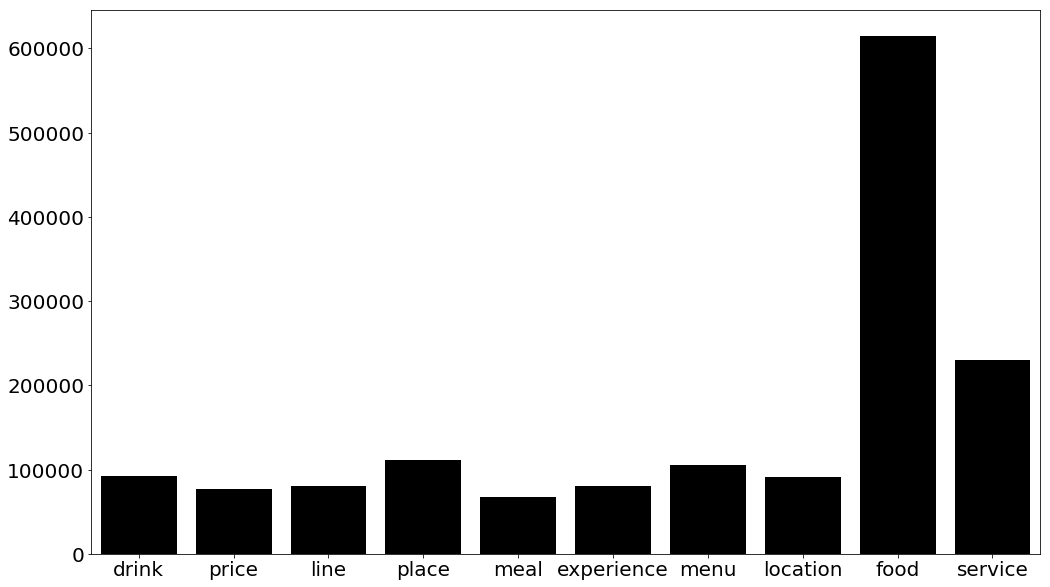

In [332]:
sns.set_context({"figure.figsize": (17, 10)})
plot = sns.barplot(x = summary.index, 
            y = summary, color = "black")

for item in ([plot.xaxis.label, plot.yaxis.label] +
             plot.get_xticklabels() + plot.get_yticklabels()):
    item.set_fontsize(20)
    
figure = plot.get_figure()    
figure.savefig('topics.svg', dpi=400)

In [271]:

summary.index

Index(['drink', 'price', 'line', 'place', 'meal', 'experience', 'menu',
       'location', 'all_food', 'all_service'],
      dtype='object')

In [228]:
topic_assignment_new = AssignTopics(topics_new)

In [244]:
topic_assignment_new_df = pd.DataFrame(topic_assignment_new)

In [248]:
topic_assignment_new_df.head(10)

,drink,bell,review,price,service,customer,chip,line,food,place,taco,meat,staff,meal,experience,menu,rice,location,salsa,chipotle
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
topic_assignment_new_df

In [249]:
topic_assignment_new_df.sum()

drink          91868.0
bell           77778.0
review         77590.0
price          77016.0
service       123986.0
customer       88861.0
chip           69060.0
line           80040.0
food          143314.0
place         110981.0
taco          120564.0
meat           80970.0
staff         113430.0
meal           66959.0
experience     80828.0
menu          105349.0
rice          111750.0
location       90702.0
salsa          92232.0
chipotle       86070.0
dtype: float64